# Sequential Actor-Critic Example

##### Imports

In [1]:
import warnings
from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)

In [2]:
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm
from kilroyplot.plot import plt
from kilroyshare.codec import Codec
from kilroytorch.modules.offline import BasicOfflineModule as OfflineModule
from kilroytorch.modules.online import ActorCriticOnlineModule as OnlineModule
from kilroytorch.models.distribution.sequential import (
    CategoricalSequentialDistributionModel as DistributionModel,
)
from kilroytorch.models.reward.sequential import (
    DiscreteSequentialRewardModel as RewardModel,
)
from kilroytorch.adapters import SequentialDataAdapter as Adapter
from kilroytorch.generators import SequentialGenerator as Generator
from kilroytorch.samplers.categorical import ProportionalCategoricalSampler as Sampler
from kilroytorch.losses.distribution import NegativeLogLikelihoodLoss as Loss
from kilroytorch.utils import unpack_to_list

##### Helpers

In [3]:
def position_values(xs, positions):
    return [[x[i] for x in xs if len(x) > i] for i in positions]


def natural_bins(a, b=None):
    a, b = (0, a) if b is None else (a, b)
    return np.arange(a - 0.5, b + 1)


def class_bins(n_classes):
    return natural_bins(0, n_classes - 1)


def chunks(data, size):
    for i in range(0, len(data), size):
        yield data[i : i + size]


def generate(generator, model, codec, n):
    return [
        codec.encode(sample)
        for sample in unpack_to_list(generator.generate(model, n)[0])
    ]

## Task

Let's assume the values of the score function for all classes are like shown below.

In [4]:
n_classes = 5
max_length = 10

In [5]:
score = lambda value: -1 if len(value) > 5 else value.count(4) + value.count(3)

Text(0, 0.5, 'sequence')

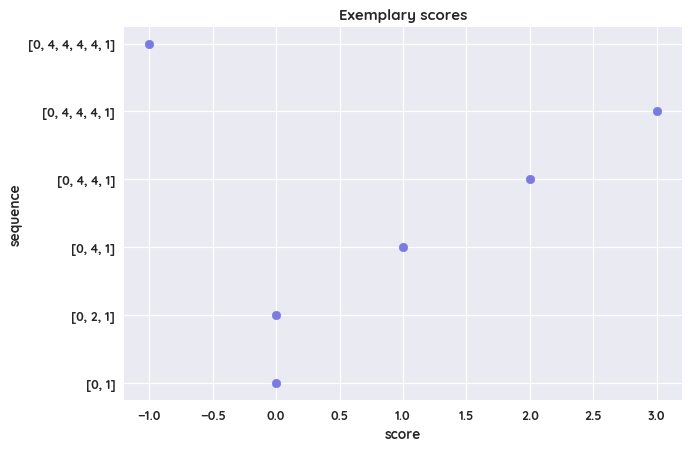

In [6]:
sequences = [
    [0, 1],
    [0, 2, 1],
    [0, 4, 1],
    [0, 4, 4, 1],
    [0, 4, 4, 4, 1],
    [0, 4, 4, 4, 4, 1],
]
plt.scatter([score(seq) for seq in sequences], [str(seq) for seq in sequences])
plt.title("Exemplary scores")
plt.xlabel("score")
plt.ylabel("sequence")

## Model

In [7]:
class DummyCodec(Codec):
    def encode(self, value):
        return value.flatten().tolist()

    def decode(self, value):
        return torch.tensor(value).view(-1, 1)

In [8]:
actor = DistributionModel(n_classes)
critic = RewardModel(n_classes)
codec = DummyCodec()
adapter = Adapter()
generator = Generator(Sampler(), max_length)
offline_module = OfflineModule(
    actor, adapter, codec, optim.Adam(actor.parameters(), lr=0.05), Loss()
)
online_module = OnlineModule(
    actor,
    critic,
    generator,
    adapter,
    codec,
    (
        optim.Adam(actor.parameters(), lr=0.001),
        optim.Adam(critic.parameters(), lr=0.001),
    ),
    actor_iterations=10,
)

## Offline

Let's assume real samples have each value in sequence (excluding start and end) sampled from binomial distribution and sequences are maximum length.

In [9]:
n_samples = 1000
samples = np.hstack(
    (
        np.zeros((n_samples, 1)),
        np.random.binomial(n_classes - 3, 0.5, (n_samples, (max_length // 2) - 2)) + 2,
        np.ones((n_samples, 1)),
    )
).astype(int)

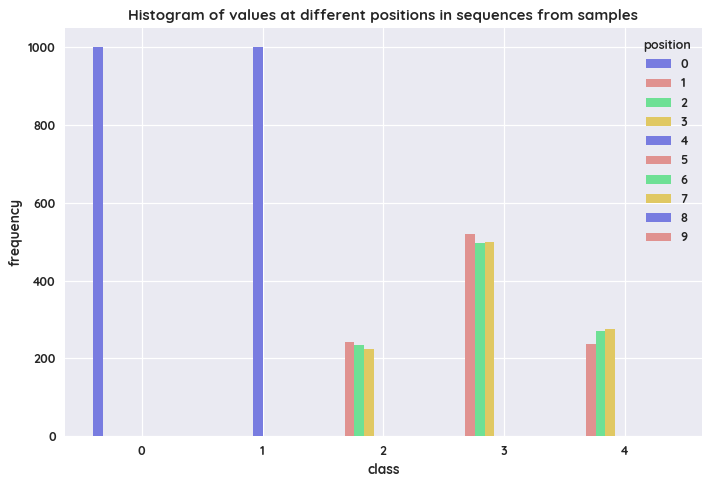

In [10]:
plt.hist(position_values(samples, range(max_length)), bins=class_bins(n_classes))
plt.title("Histogram of values at different positions in sequences from samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.legend(range(max_length), title="position")
plt.tight_layout()

In [11]:
n_epochs = 100
batch_size = 512
losses = []

for _ in tqdm(range(n_epochs)):
    epoch_losses = []
    for batch in chunks(samples, batch_size):
        metrics = offline_module.fit(batch)
        epoch_losses.append(metrics["loss"])
        offline_module = offline_module.step()
    losses.append(np.mean(epoch_losses))

100%|██████████| 100/100 [00:02<00:00, 46.54it/s]


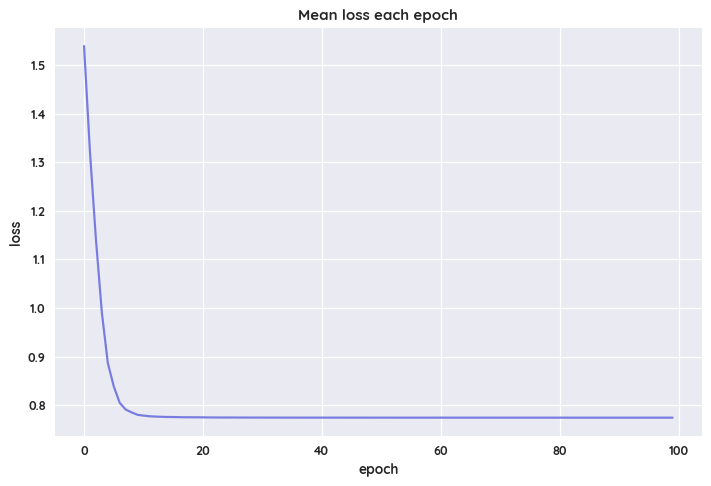

In [12]:
plt.plot(losses)
plt.title("Mean loss each epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

In [13]:
samples = generate(generator, actor, codec, 1000)

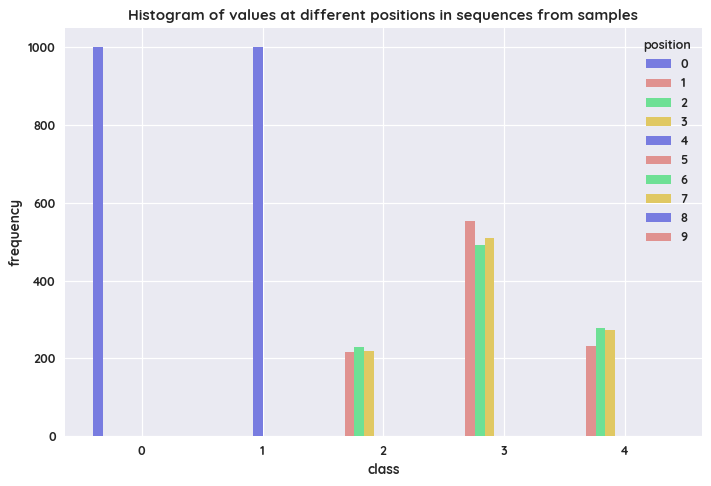

In [14]:
plt.hist(position_values(samples, range(max_length)), bins=class_bins(n_classes))
plt.title("Histogram of values at different positions in sequences from samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.legend(range(max_length), title="position")
plt.tight_layout()

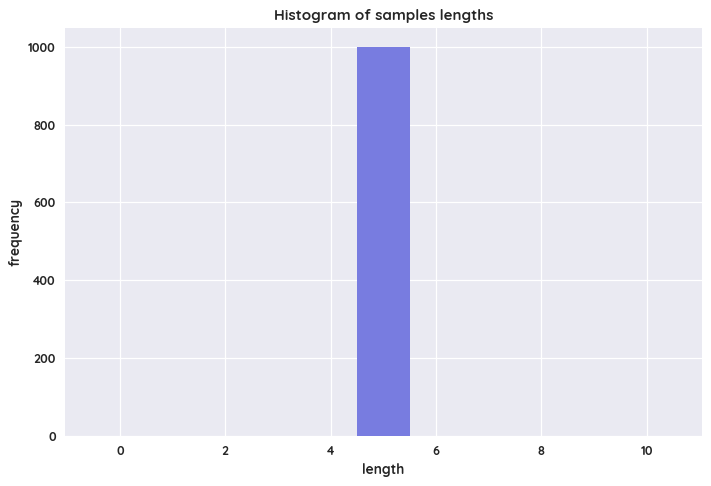

In [15]:
plt.hist([len(s) for s in samples], bins=natural_bins(max_length))
plt.title("Histogram of samples lengths")
plt.xlabel("length")
plt.ylabel("frequency")
plt.tight_layout()

## Online

In [16]:
n_iters = 1000
iter_size = 512
critic_losses = []
actor_losses = []
mean_scores = []

for _ in tqdm(range(n_iters)):
    scores = {key: score(value) for key, value in online_module.sample(iter_size)}
    mean_scores.append(np.mean(list(scores.values())))
    metrics = online_module.fit(scores)
    critic_losses.append(metrics["critic_loss"])
    actor_losses.append(metrics["actor_loss"])
    online_module = online_module.step()

100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


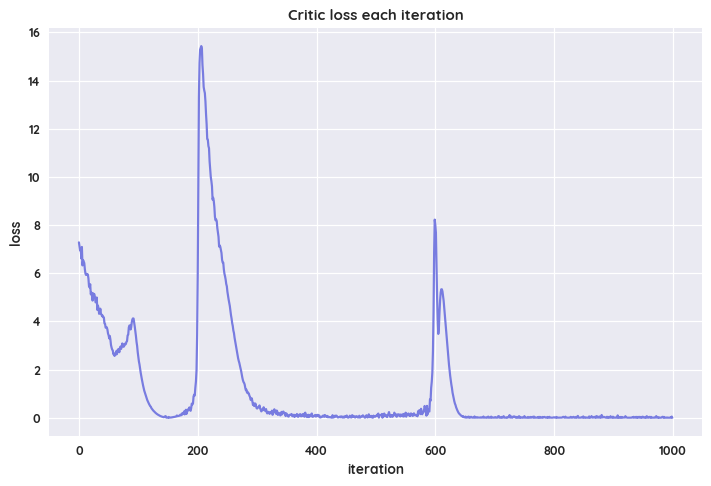

In [17]:
plt.plot(critic_losses)
plt.title("Critic loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

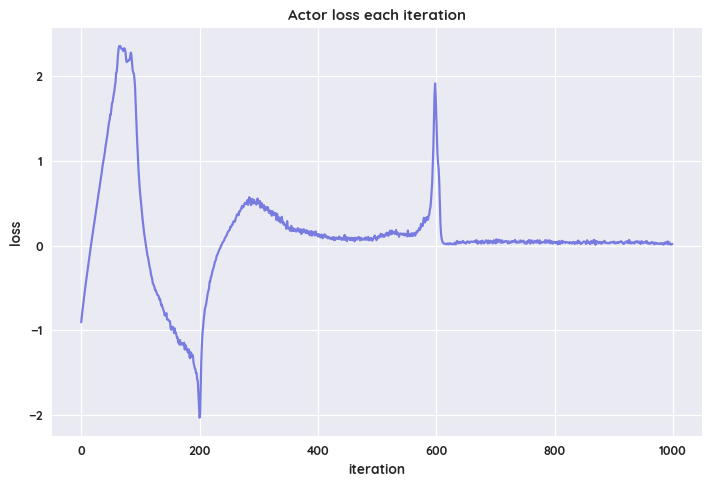

In [18]:
plt.plot(actor_losses)
plt.title("Actor loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

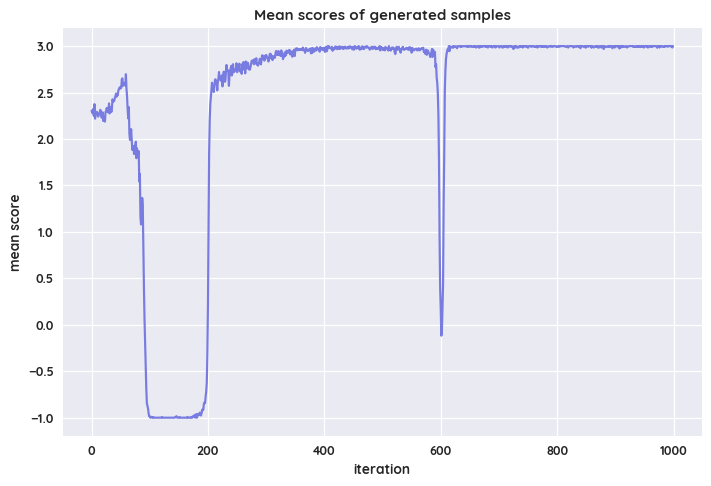

In [19]:
plt.plot(mean_scores)
plt.title("Mean scores of generated samples")
plt.xlabel("iteration")
plt.ylabel("mean score")
plt.tight_layout()

In [20]:
samples = generate(generator, actor, codec, 1000)

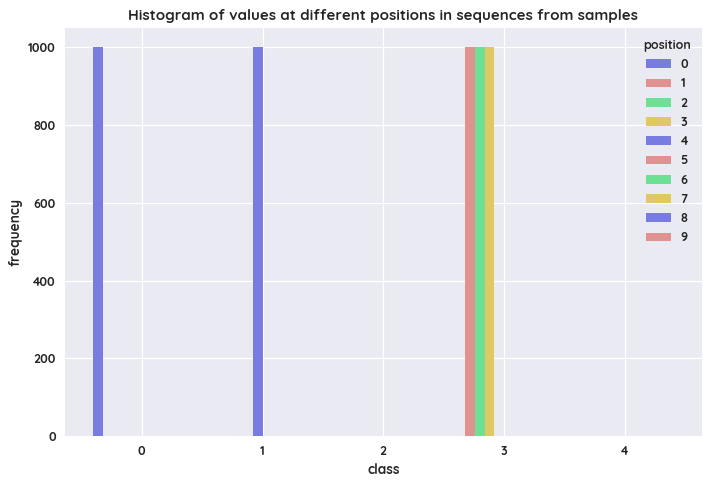

In [21]:
plt.hist(position_values(samples, range(max_length)), bins=class_bins(n_classes))
plt.title("Histogram of values at different positions in sequences from samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.legend(range(max_length), title="position")
plt.tight_layout()

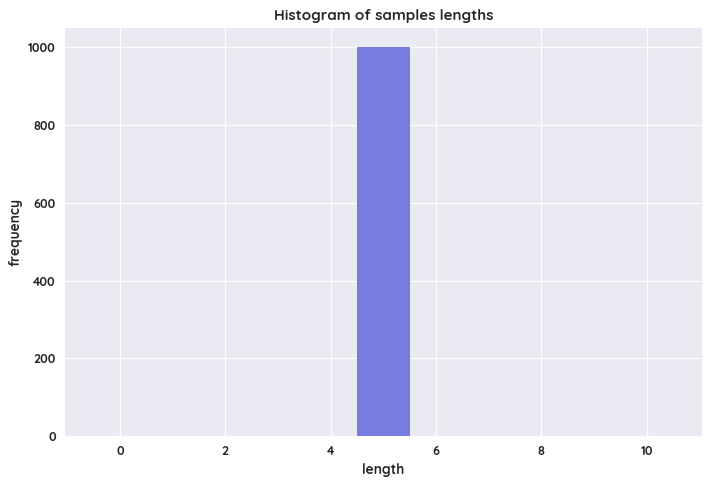

In [22]:
plt.hist([len(s) for s in samples], bins=natural_bins(max_length))
plt.title("Histogram of samples lengths")
plt.xlabel("length")
plt.ylabel("frequency")
plt.tight_layout()